# Ejemplo de Clustering con HDBSCAN

Por: [Eduardo Graells-Garrido](http://datagramas.cl), <egraells@udd.cl>

En la clase vimos cómo funciona _k-means_, un algoritmo sencillo de clustering no supervisado que puede ser útil y versátil.

Sin embargo, una de sus limitaciones están:

- Se requiere conocer de antemano el número de clusters.
- La separación entre clusters es lineal.

Y una característica que no conversamos, pero que puede ser relevante, es:

- Todos los puntos del dataset por definición pertenecen a un cluster.

¿Qué hacer cuando alguno de esos puntos hace que _k-means_ no sea adecuado para nuestro proyecto?

Un algoritmo que no tiene ninguno de esos _peros_ es DBSCAN, que está disponible en ``sklearn.cluster.DBSCAN``.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/800px-DBSCAN-Illustration.svg.png)

Su nombre significa "barrido basado en densidad." Lo que hace DBSCAN es definir tres tipos de puntos en función de los otros puntos que lo rodean:

- _Núcleos_ (puntos rojos): conjuntos de puntos que, entre sí, están dentro de un radio de distancia y, en total, son más que una cierta cantidad especificada como hiperparámetro.
- _Puntos Alcanzables_ (puntos amarillos): puntos que no son núcleos, pero que están dentro del umbral de tolerancia de distancia a puntos núcleos.
- _Ruido_ (punto azul): puntos que no son alcanzables desde los núcleos.

Considerando eso, se vuelve intuitivo el hecho de que no necesitamos especificar el número de clusters, sino el umbral de distancia para la densidad, y, por tanto, que la forma de los clusters puede ser arbitraria. Al mismo tiempo, habrá puntos que no estarán agrupados en clusters.

Veremos un ejemplo de aplicar una versión de DBSCAN que está en el estado del arte, conocida como [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) (por Hierarchical DBSCAN). Para instalarla debemos utilizar el siguiente comando:

`pip install hdbscan`

Su API es la misma de Scikit-Learn, así que será sencillo familiarizarnos con su uso.

La diferencia entre HDBSCAN y DBSCAN es que HDBSCAN tiene una noción de distancia umbral flexible. Esto es útil cuando la densidad de los puntos varía y, por tanto, un único umbral podría llevar a resultados erróneos.

## Datos: Encuesta Origen Destino de Viajes, Santiago 2012

Utilizaremos datos de viajes en Santiago, capturados el año 2012 a través de encuestas. Estos datos son utilizados para gestión y planificación de transporte, urbanismo, sociología, y más. En el Instituto de Data Science también los usamos, sobretodo como datos de comparación con los modelos de transporte y movilidad que generamos.

**Importante**: Como esto es un ejemplo, ignoraremos el _factor de expansión_ en la encuesta. Este atributo es imprescindible a la hora de sacar conclusiones a partir de los datos, porque contiene el **peso** que tiene cada observación. 

**Fuentes**: los mapas que usaremos provienen de la [Biblioteca del Congreso Nacional](https://www.bcn.cl/siit/mapas_vectoriales/index_html), y la encuesta proviene del [Portal de Datos del Gobierno](http://datos.gob.cl/dataset/31616).

## Preámbulo

Además de `pandas` utilizaremos `geopandas`, una biblioteca que extiende a `pandas` con soporte de datos geográficos. La utilizaremos para poder visualizar los bordes de las municipalidades de Santiago.

In [1]:
# análisis
import pandas as pd
import geopandas as gpd
import numpy as np

# clustering
from hdbscan import HDBSCAN

# visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.colors import rgb2hex

# Esto configura la apariencia de los gráficos utilizando configuraciones de seaborn
sns.set(context='notebook', style='ticks', palette='inferno', font='Linux Biolinum O', font_scale=1.1)

# Esto es una instrucción de Jupyter que hace que los gráficos se desplieguen en el notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Datos Geográficos

Aquí utilizaremos `geopandas` y distintas fuentes de datos geográficos para poder tener un marco de referencia de los bordes municipales. Como lo haremos estrictamente para visualización, no profundizaremos en lo que sucede aquí.

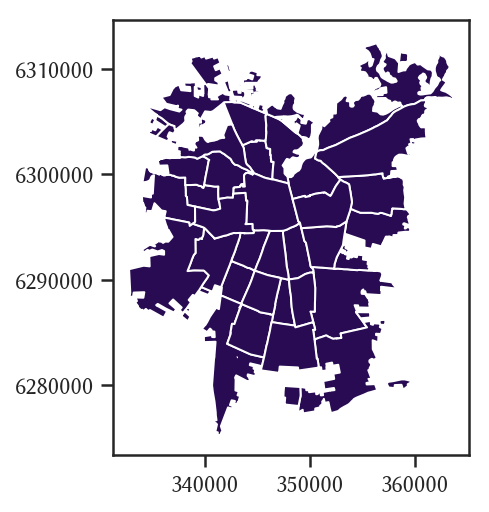

In [2]:
urban_areas = gpd.read_file('./data/urban_areas/', crs={'init': 'epsg:5361'})
municipalities = gpd.read_file('./data/shapefile_comunas/', crs={'init': 'epsg:5361'})
stgo_municipalities = gpd.sjoin(municipalities, urban_areas[urban_areas.NOMBRE == 'Santiago'], op='intersects')

def intersection(municipality, urban_area):
    return municipality.intersection(urban_area)

def urban_part(municipality):
    return intersection(municipality, urban_areas[urban_areas.NOMBRE == 'Santiago'].geometry.values[0])

stgo_urban_municipalities = (stgo_municipalities.copy()
                             .assign(geometry=lambda df_: df_['geometry'].map(urban_part))
                             .pipe(lambda x: x[~x.NOM_COM.isin(['Lampa', 'Colina'])]))

stgo_urban_municipalities.plot()

#### Datos de Viajes

He preparado una versión compacta de los datos de la encuesta. Aquí los cargamos y preprocesamos:

In [3]:
trips = pd.read_csv('./data/stgo-travel-survey-2012.csv.gz')
trips.sample(5)

Viaje   Hogar   Persona  Etapas      ComunaOrigen  \
72987  2792710203  279271  27927102       1          Santiago   
57103  2399400101  239940  23994001       1         Quilicura   
6507   1220010202  122001  12200102       1  Estación Central   
49413  2209120402  220912  22091204       1       Providencia   
31376  1756110203  175611  17561102       1             Maipú   

          ComunaDestino SectorOrigen SectorDestino  ZonaOrigen  ZonaDestino  \
72987       Providencia       Centro       Oriente          48          508   
57103         Quilicura        Norte         Norte         544          556   
6507   Estación Central     Poniente      Poniente         136          133   
49413       Providencia      Oriente       Oriente         500          497   
31376             Maipú     Poniente      Poniente         386          383   

       ...        Sector            Comuna  home_latitude  home_longitude  \
72987  ...       Oriente          VITACURA     -33.388275      -70.575624   
57103  ...         Norte         QUILICURA     -33.363125      -70.749519   
6507   ...      Poniente  ESTACION CENTRAL     -33.472076      -70.717163   
49413  ...   Sur-Oriente       PUENTE ALTO     -33.574600      -70.569496   
31376  ...      Poniente             MAIPU     -33.522102      -70.790398   

      NumPer  NumVeh NumBicAdulto NumBicNino IngresoHogar  Zona  
72987      3       1            0          0      7894946   667  
57103      4       0            0          2      1990393   544  
6507       3       0            0          0       100000   133  
49413      6       1            1          1      1540468   701  
31376      3       2            0          0       411184   386  

[5 rows x 59 columns]

In [4]:
trips.columns

Index(['Viaje', 'Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
       'DistEuclidiana', 'DistManhattan', 'Imputada', 'HoraDeInicio', 'Sexo',
       'TramoIngreso', 'Ocupacion', 'JornadaTrabajo', 'Relacion',
       'origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'Sector', 'Comuna', 'home_latitude',
       'home_longitude', 'NumPer', 'NumVeh', 'NumBicAdulto', 'NumBicNino',
  

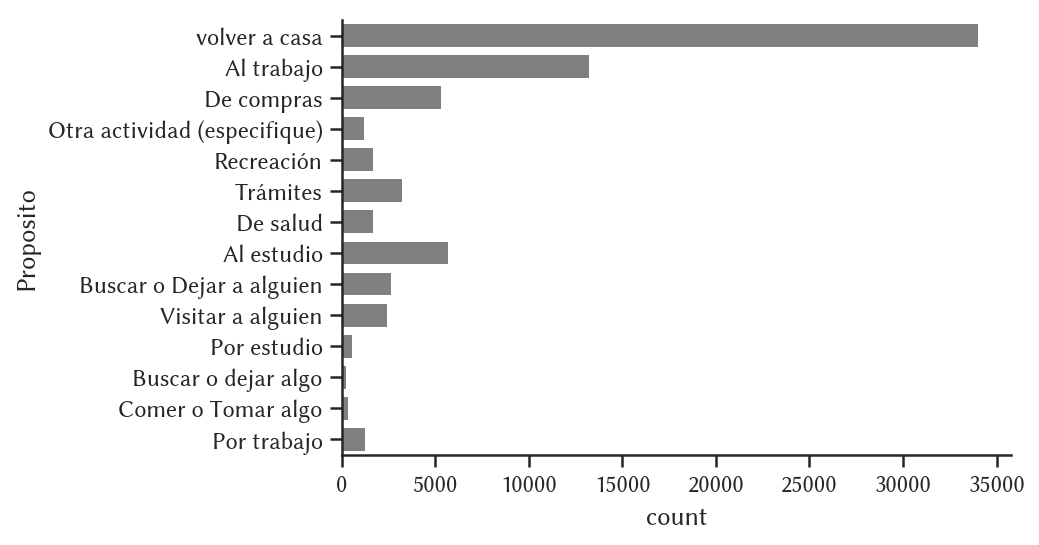

In [5]:
sns.countplot(y=trips['Proposito'], color='grey')
sns.despine()

Visualicemos los destinos de esos viajes:

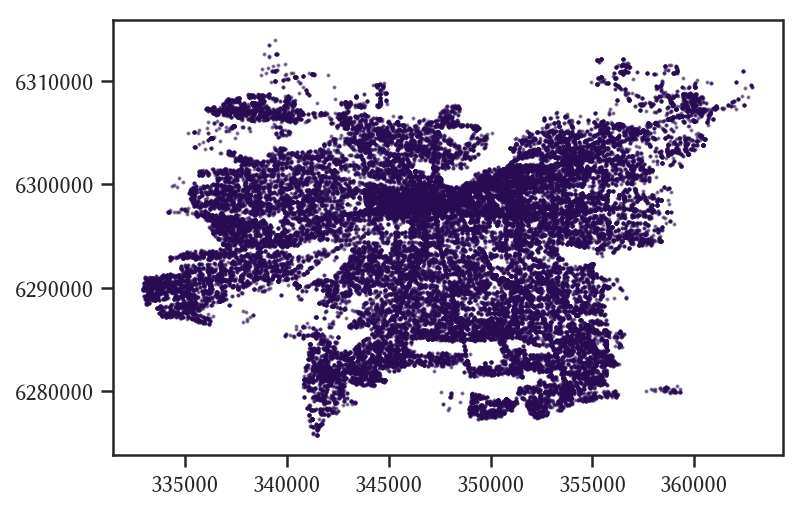

In [9]:
plt.scatter(trips.DestinoCoordX, trips.DestinoCoordY, s=1, alpha=0.5)

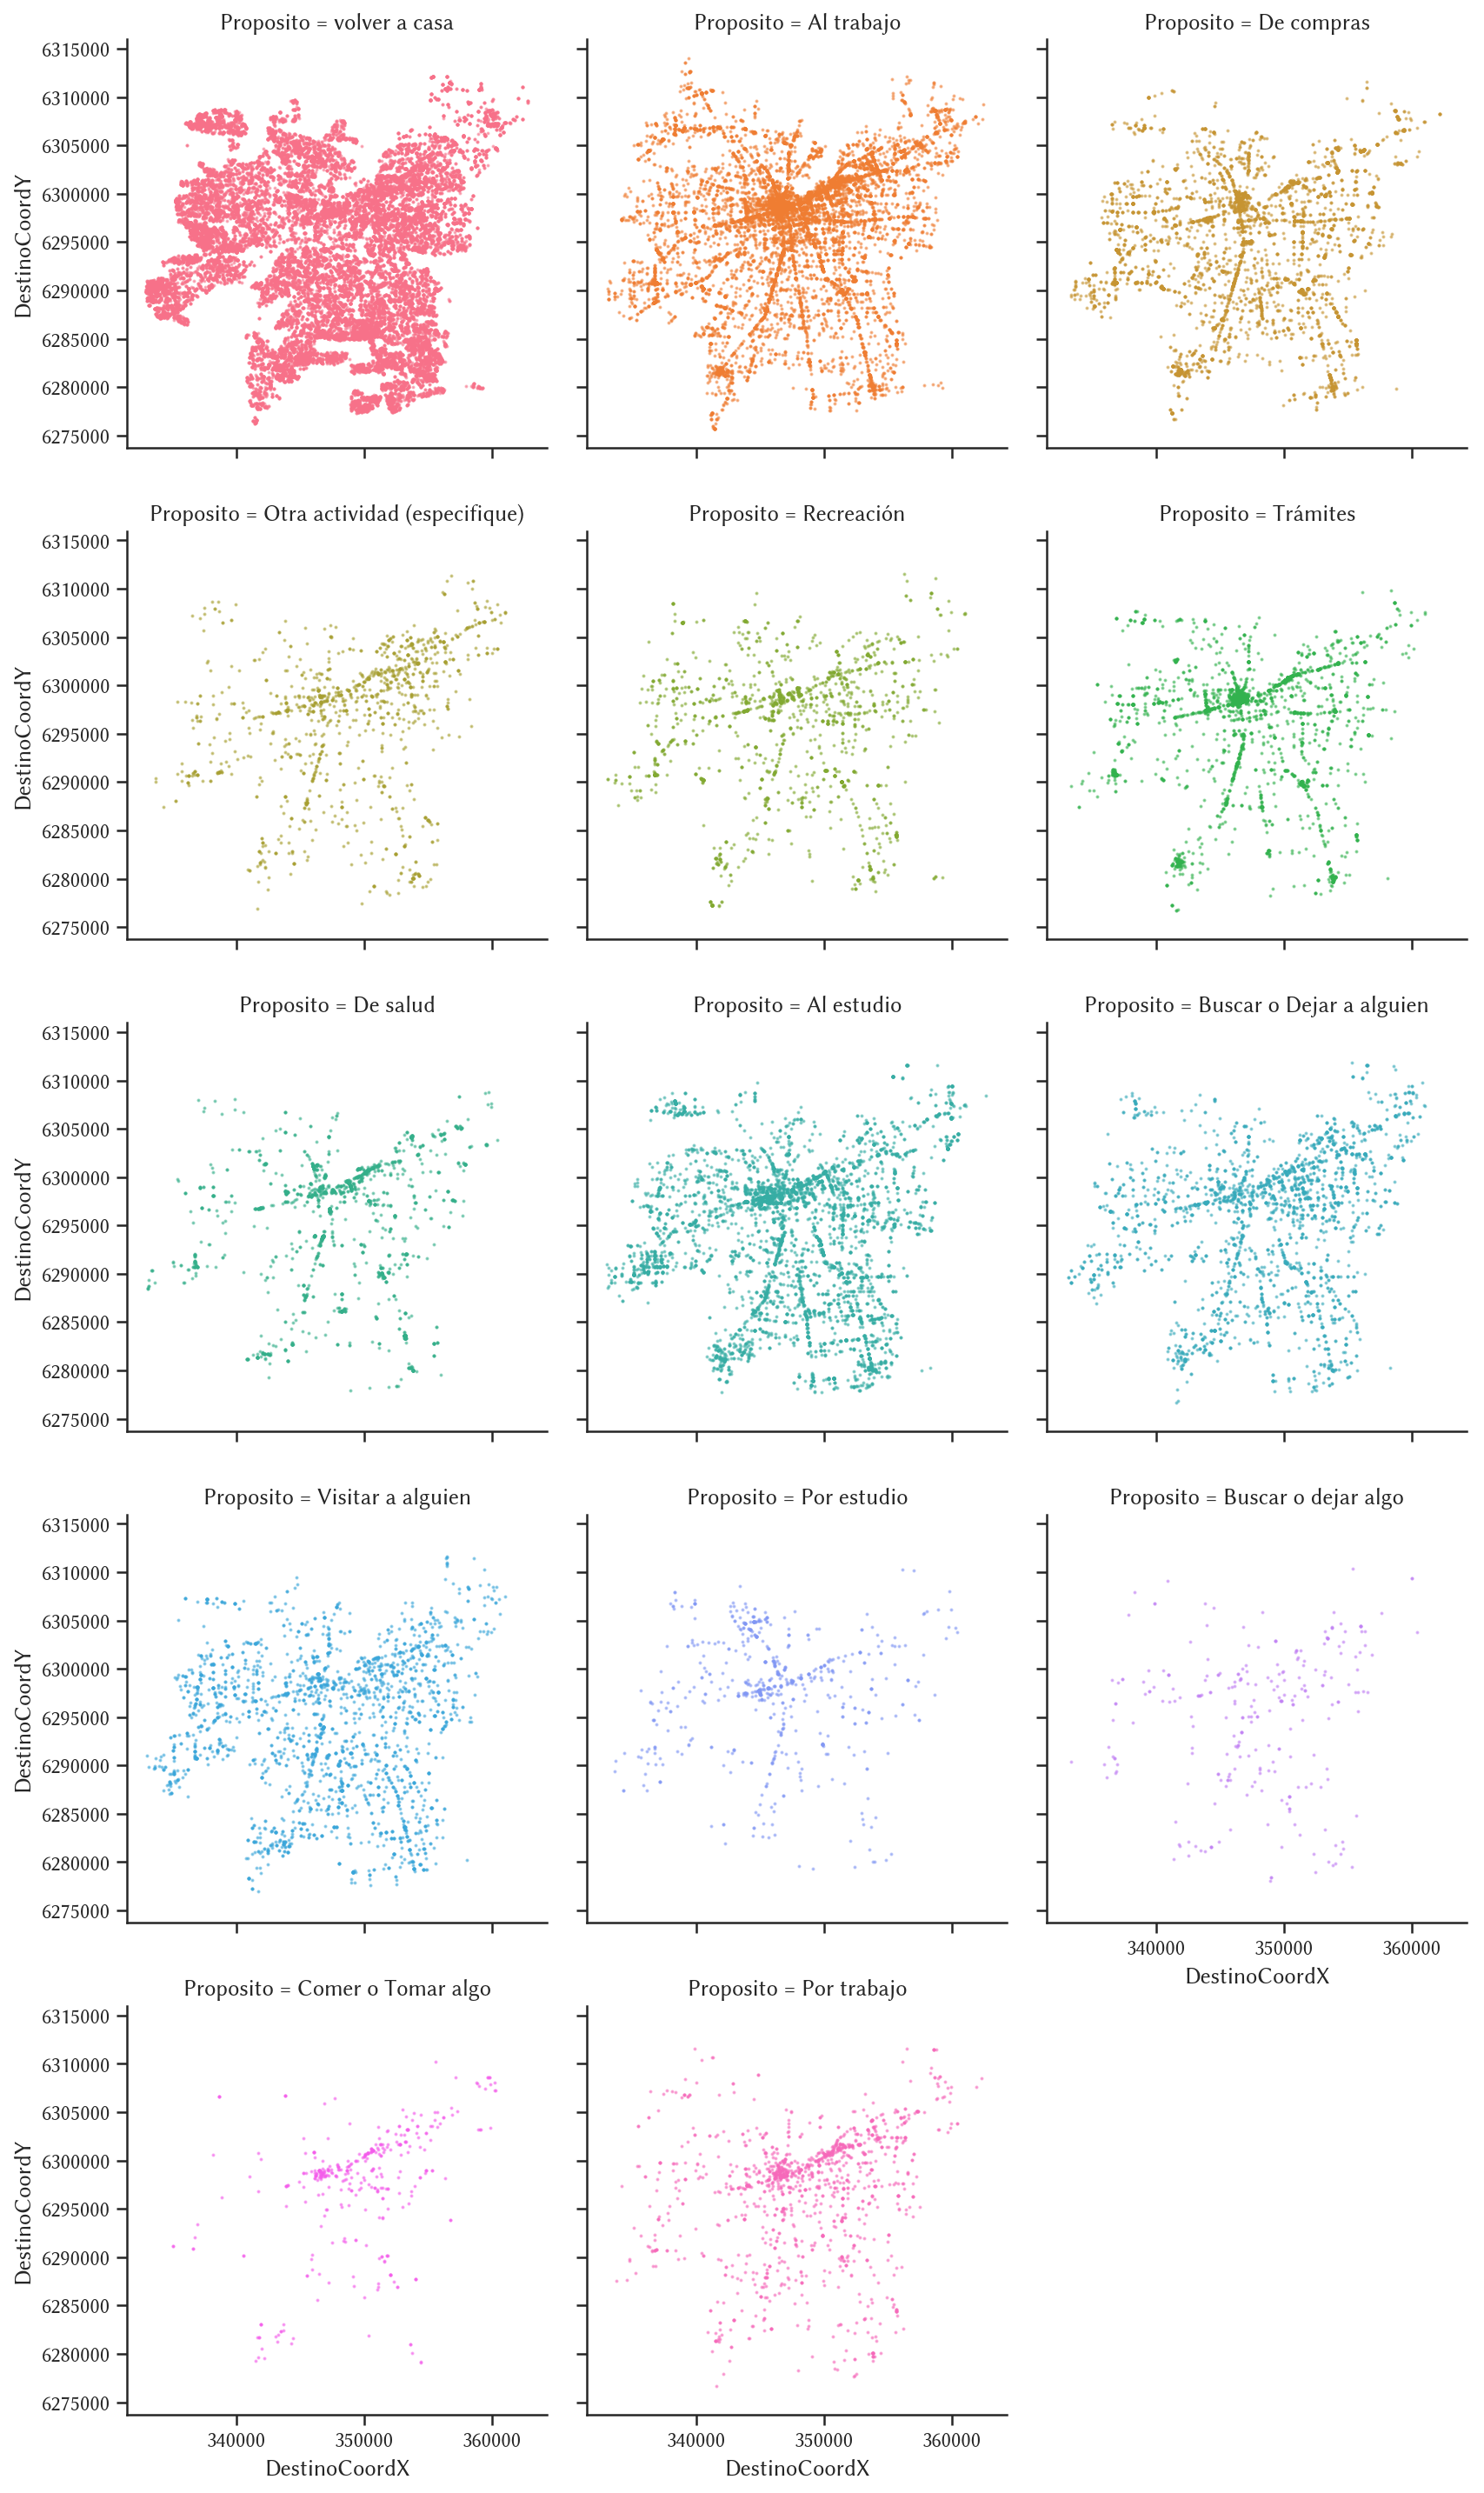

In [6]:
g = sns.FacetGrid(data=trips, col='Proposito', hue='Proposito', aspect=1, height=4, col_wrap=3)
g.map(plt.scatter, 'DestinoCoordX', 'DestinoCoordY', alpha=0.5, s=1)

## Mini-Proyecto: ¿Cuántos Centros hay en la Ciudad?¿Qué los caracteriza?

Como vemos en las imágenes previas, viajes hay en toda la ciudad. Sin embargo, sabemos que no todos los sectores de la ciudad reciben afluencias grandes de personas.

El centro de Santiago es sólo uno, pero lugares que concentran actividades hay varios. Entonces, ¿cuántos son? Saberlo nos permitiría apoyar la planificación de la red de transporte, el fomento de instalación en centros sub-desarrollados, o incluso la identificación de oportunidades para crear un nuevo centro.

Definiremos como _centro_ un espacio de la ciudad en el que se concentran actividades. Y, utilizando Machine Learning no supervisado, buscaremos una manera de responder la pregunta, **agrupando los destinos de los viajes como una señal de la afluencia que tiene un lugar**.

### Elección de Viajes a Considerar

No todos los viajes son iguales. Como vemos en el primer gráfico, los viajes de regreso a casa son los más frecuentes, y están dispersos por toda la ciudad. Lo que queremos son estudiar _las actividades que se hacen fuera de casa_.

Por simplificidad nos enfocaremos en las dos actividades más frecuentes que siguen a volver a casa: trabajar y estudiar.

In [10]:
analysis_trips = trips[trips['Proposito'].isin(['Al trabajo', 'Al estudio'])].copy()
len(analysis_trips)

18966

Creamos nuestra matriz de características: las posiciones de los viajes.

In [11]:
X = analysis_trips[['DestinoCoordX', 'DestinoCoordY']].values
X.shape

(18966, 2)

Realizamos el procedimiento estándar:

- Inicializar instancia del modelo (que ya importamos en el preámbulo) con sus hiperparámetros. Usaremos dos: 
  - `min_cluster_size`: cantidad mínima de viajes para considerar un cluster.
  - `min_samples`: cantidad mínima de puntos núcleo para considerar un cluster.
- Ajustar la matriz de características `X`
- Predecir el vector de etiquetas `y`

Los últimos dos pasos los podemos realizar en una sola llamada al método `fit_predict(X)`:

In [37]:
dbscan = HDBSCAN(min_cluster_size=400, min_samples=25)
analysis_trips['cluster'] = dbscan.fit_predict(X)
cluster_ids = analysis_trips['cluster'].value_counts()
len(cluster_ids) - 1

9

Con esos hiperparámetros tenemos 9 clusters. Ésta es la cantidad de viajes que poseen:

In [38]:
cluster_ids

-1    10711
 6     2255
 8     1734
 3      912
 1      808
 4      604
 0      587
 7      474
 5      472
 2      409
Name: cluster, dtype: int64

Para identificar los clusters utilizaremos una paleta de colores conocida como `husl`, que varía el tono de un color a otro:

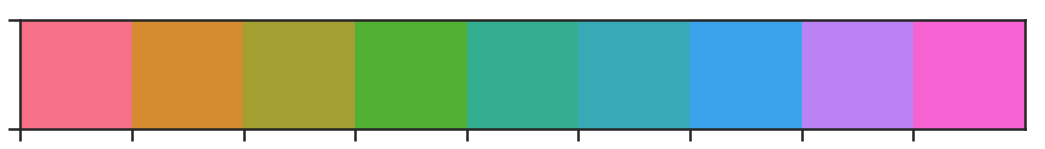

In [39]:
colors = sns.color_palette('husl', n_colors=len(cluster_ids) - 1)
sns.palplot(colors)

Crearemos un diccionario para pintar los puntos de los clusters. Le asignaremos el color gris a los puntos de ruido:

In [40]:
palette = dict(zip(range(len(cluster_ids) - 1), map(rgb2hex, colors)))
palette[-1] = '#afafaf'
palette

{-1: '#afafaf',
 0: '#f77189',
 1: '#d58c32',
 2: '#a4a031',
 3: '#50b131',
 4: '#34ae91',
 5: '#37abb5',
 6: '#3ba3ec',
 7: '#bb83f4',
 8: '#f564d4'}

Aquí utilizaremos una mezcla entre `geopandas` y `matplotlib` para visualizar los resultados:

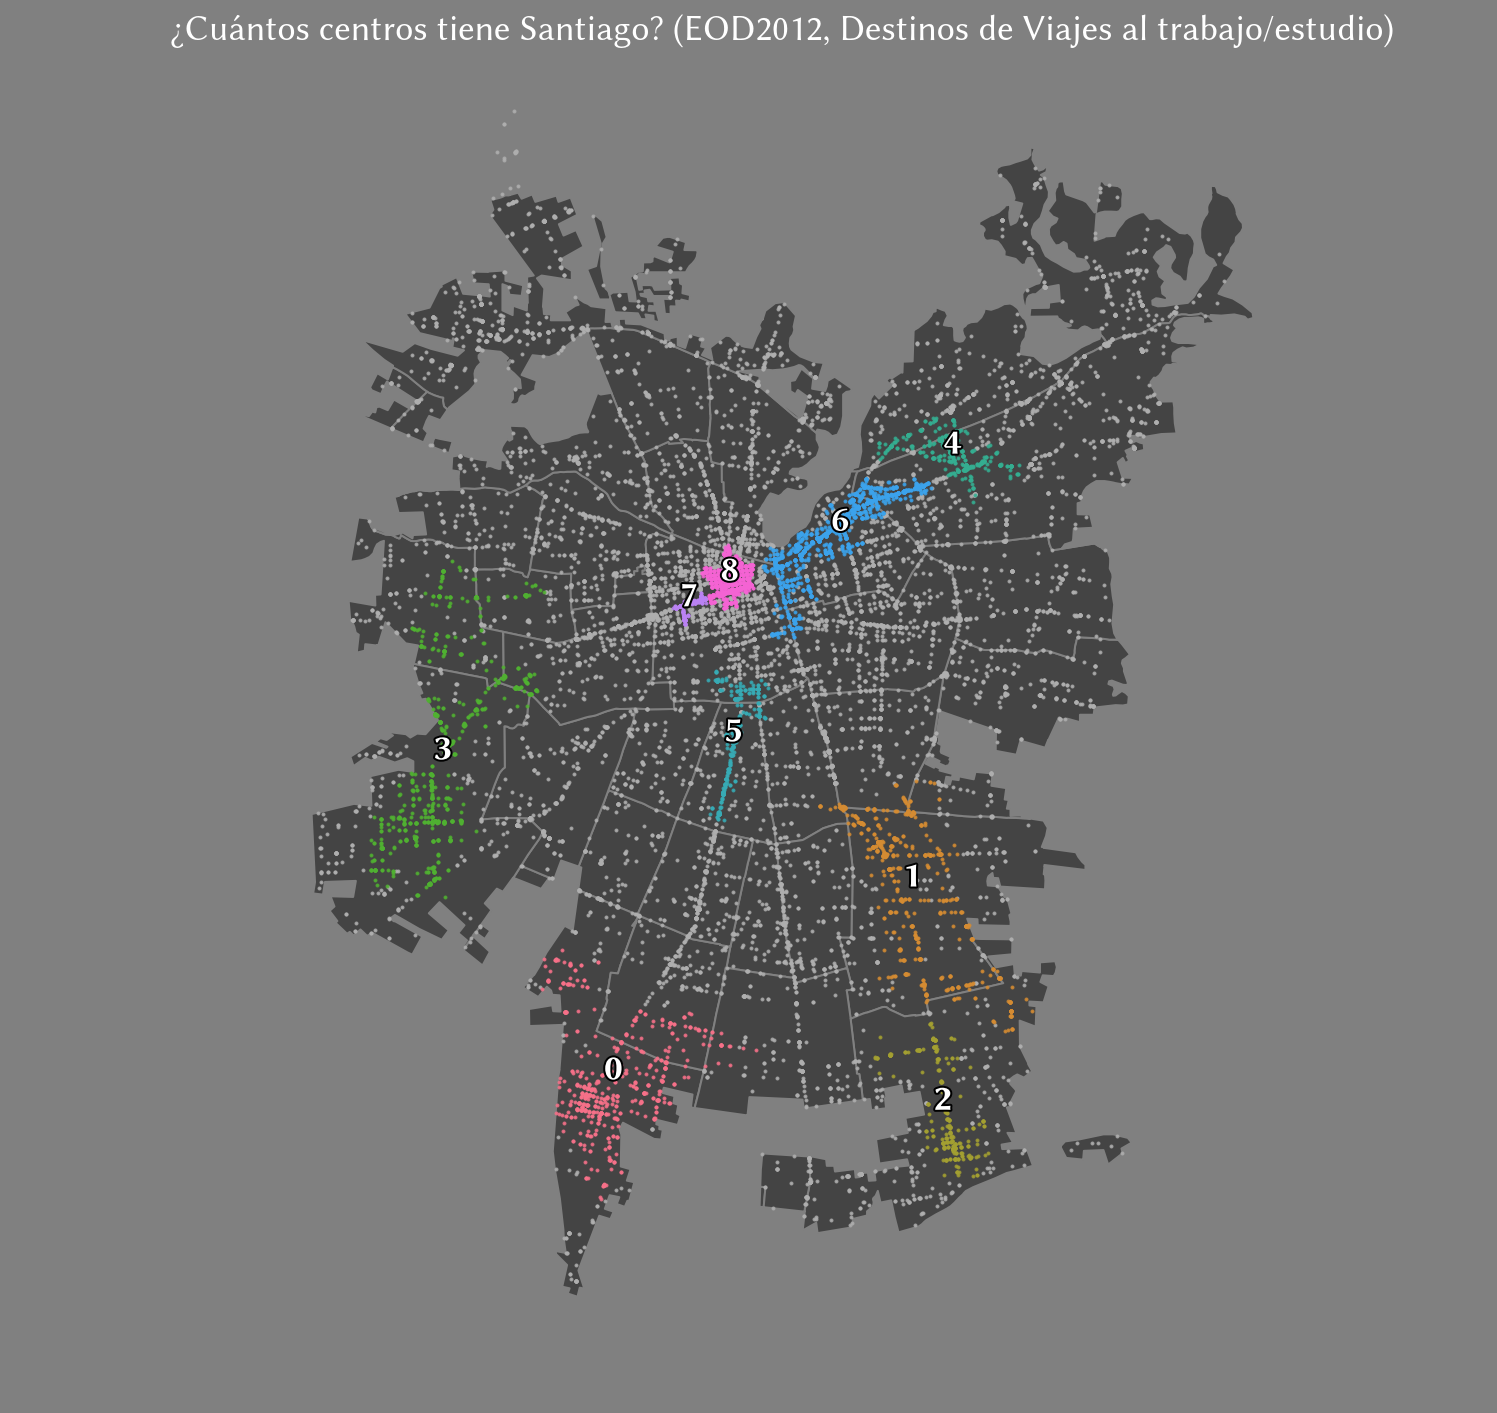

In [41]:
# creamos la figura
plt.figure(figsize=(12, 12), facecolor='grey')

# este método entrega el "eje" (axis) donde se grafica actualmente
ax = plt.gca()

# graficamos los bordes de las municipalidades en el eje
stgo_urban_municipalities.plot(ax=ax, edgecolor='grey', facecolor='#444444')

# pintamos los puntitos de cada cluster
for cluster_id in sorted(cluster_ids.index):
    # viajes correspondientes a cada cluster
    cluster_trips = analysis_trips[analysis_trips.cluster == cluster_id]
    
    # dibujamos directamente con matplotlib
    plt.plot(cluster_trips.DestinoCoordX, cluster_trips.DestinoCoordY, '.', alpha=0.8, markersize=2, color=palette[cluster_id])
    
    # para los clusters, agregamos la etiqueta correspondiente para poder identificarlos
    # pondremos la etiqueta en el promedio de las posiciones que tiene cada cluster
    if cluster_id >= 0:
        t = plt.text(cluster_trips.DestinoCoordX.mean(), cluster_trips.DestinoCoordY.mean(), str(cluster_id), 
                     horizontalalignment='center', fontsize=18, fontweight='bold', color='white')
        
        # éste es un efecto gráfico que facilita la comprensión del texto
        t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        
# configuraciones del gráfico:
# - radio de aspecto 1:1
plt.axis('equal')
# - título, no puede faltar!
plt.title('¿Cuántos centros tiene Santiago? (EOD2012, Destinos de Viajes al trabajo/estudio)', fontsize=18, color='white')
# - no dibujes las coordenadas, no las necesitamos. Aquí todes conocemos el contexto.
plt.axis('off');

¿Qué les parecen los resultados?

Consideraciones:

- El centro histórico está correctamente identificado.
- El eje Providencia aparece como un gran centro, y parte de Vitacura y Las Condes también. Esto es coherente con los distritos comerciales y de negocios que hay en el sector.
- ¿Maipú y San Bernardo casi completas son centros? Seguramente hay que ajustar algo, porque si bien podrían serlo (sobretodo el centro de Maipú), su extensión no es tan larga.
- Plaza de Puente Alto y Concha y Toro: esto sí tiene sentido, considerando la cantidad de lugares de trabajo y servicios que hay en esos lugares.
- Vicuña Mackenna y Avenida La Florida: ídem a lo anterior.
- Gran Avenida: también, sobretodo considerando el polo comercial que es.

Hay que jugar con los hiperparámetros para entender cómo se comporta el algoritmo, y así poder ajustarlos para obtener una mejor respuesta. Verán que algunos parámetros son más sensibles que otros, y pueden introducir grandes cambios en los resultados.

De momento, asumamos que estamos contentos con la respuesta.

### ¿Qué sigue?

El siguiente paso es buscar comprender qué caracteriza a cada uno de estos clusters.

Por ejemplo, podríamos preguntarnos cómo llega la gente a estos lugares. La encuesta tiene un atributo llamado `ModoDifusion` que indica el o los modos de transporte utilizados en el viaje:

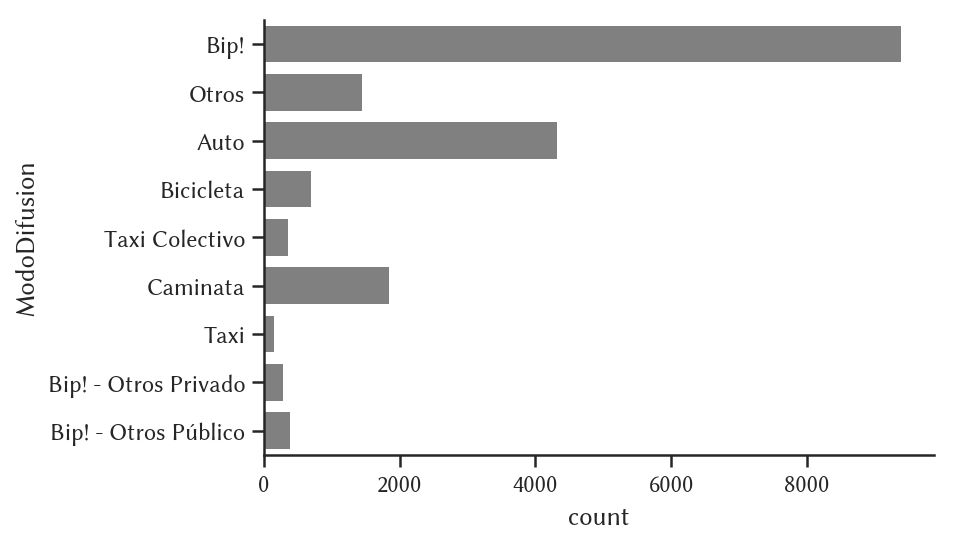

In [42]:
sns.countplot(y=analysis_trips['ModoDifusion'], color='grey')
sns.despine()

Entonces podemos hacer ese cálculo por cada modo (o combinación). Para ello utilizaremos la operación `groupby`:

In [45]:
mot_table = (analysis_trips[analysis_trips['cluster'] >= 0]
             .groupby(['cluster', 'ModoDifusion'])
             .size()
             .unstack()
             .fillna(0)
            )
mot_table

ModoDifusion   Auto  Bicicleta    Bip!  Bip! - Otros Privado  \
cluster                                                        
0             127.0       29.0   117.0                   4.0   
1             155.0       27.0   355.0                  10.0   
2              64.0       14.0   163.0                   1.0   
3             188.0       40.0   376.0                   4.0   
4             170.0       19.0   341.0                  14.0   
5             113.0        8.0   273.0                  10.0   
6             458.0       84.0  1407.0                  43.0   
7              26.0       11.0   386.0                  13.0   
8             203.0       24.0  1211.0                  35.0   

ModoDifusion  Bip! - Otros Público  Caminata  Otros  Taxi  Taxi Colectivo  
cluster                                                                    
0                             12.0     112.0  117.0   5.0            64.0  
1                             19.0      95.0  107.0   3.0            37.0  
2                              5.0      48.0   65.0   3.0            46.0  
3                             12.0     110.0  138.0   3.0            41.0  
4                             17.0      21.0   12.0  10.0             0.0  
5                             15.0      16.0   21.0   1.0            15.0  
6                             54.0     134.0   38.0  31.0             6.0  
7                             10.0      19.0    8.0   0.0             1.0  
8                             56.0     144.0   28.0  14.0            19.0

A cada cluster viaja una cantidad de gente diferente. Quisiéramos poder compararlos en función de la distribución relativa entre ellos.

Para lograrlo, podemos normalizar las filas de la tabla, dividiendo cada una por el total contenido en ellas. Así calculamos el total (el parámetro `axis` define si realizar la suma por filas -`0`- o por columnas -`1`-):

In [46]:
mot_table.sum(axis=1)

cluster
0     587.0
1     808.0
2     409.0
3     912.0
4     604.0
5     472.0
6    2255.0
7     474.0
8    1734.0
dtype: float64

Y así realizamos la división:

In [47]:
mot_table = mot_table.div(mot_table.sum(axis=1), axis=0)
mot_table

ModoDifusion      Auto  Bicicleta      Bip!  Bip! - Otros Privado  \
cluster                                                             
0             0.216354   0.049404  0.199319              0.006814   
1             0.191832   0.033416  0.439356              0.012376   
2             0.156479   0.034230  0.398533              0.002445   
3             0.206140   0.043860  0.412281              0.004386   
4             0.281457   0.031457  0.564570              0.023179   
5             0.239407   0.016949  0.578390              0.021186   
6             0.203104   0.037251  0.623947              0.019069   
7             0.054852   0.023207  0.814346              0.027426   
8             0.117070   0.013841  0.698385              0.020185   

ModoDifusion  Bip! - Otros Público  Caminata     Otros      Taxi  \
cluster                                                            
0                         0.020443  0.190801  0.199319  0.008518   
1                         0.023515  0.117574  0.132426  0.003713   
2                         0.012225  0.117359  0.158924  0.007335   
3                         0.013158  0.120614  0.151316  0.003289   
4                         0.028146  0.034768  0.019868  0.016556   
5                         0.031780  0.033898  0.044492  0.002119   
6                         0.023947  0.059424  0.016851  0.013747   
7                         0.021097  0.040084  0.016878  0.000000   
8                         0.032295  0.083045  0.016148  0.008074   

ModoDifusion  Taxi Colectivo  
cluster                       
0                   0.109029  
1                   0.045792  
2                   0.112469  
3                   0.044956  
4                   0.000000  
5                   0.031780  
6                   0.002661  
7                   0.002110  
8                   0.010957

Podemos visualizar el resultado con un `HeatMap`:

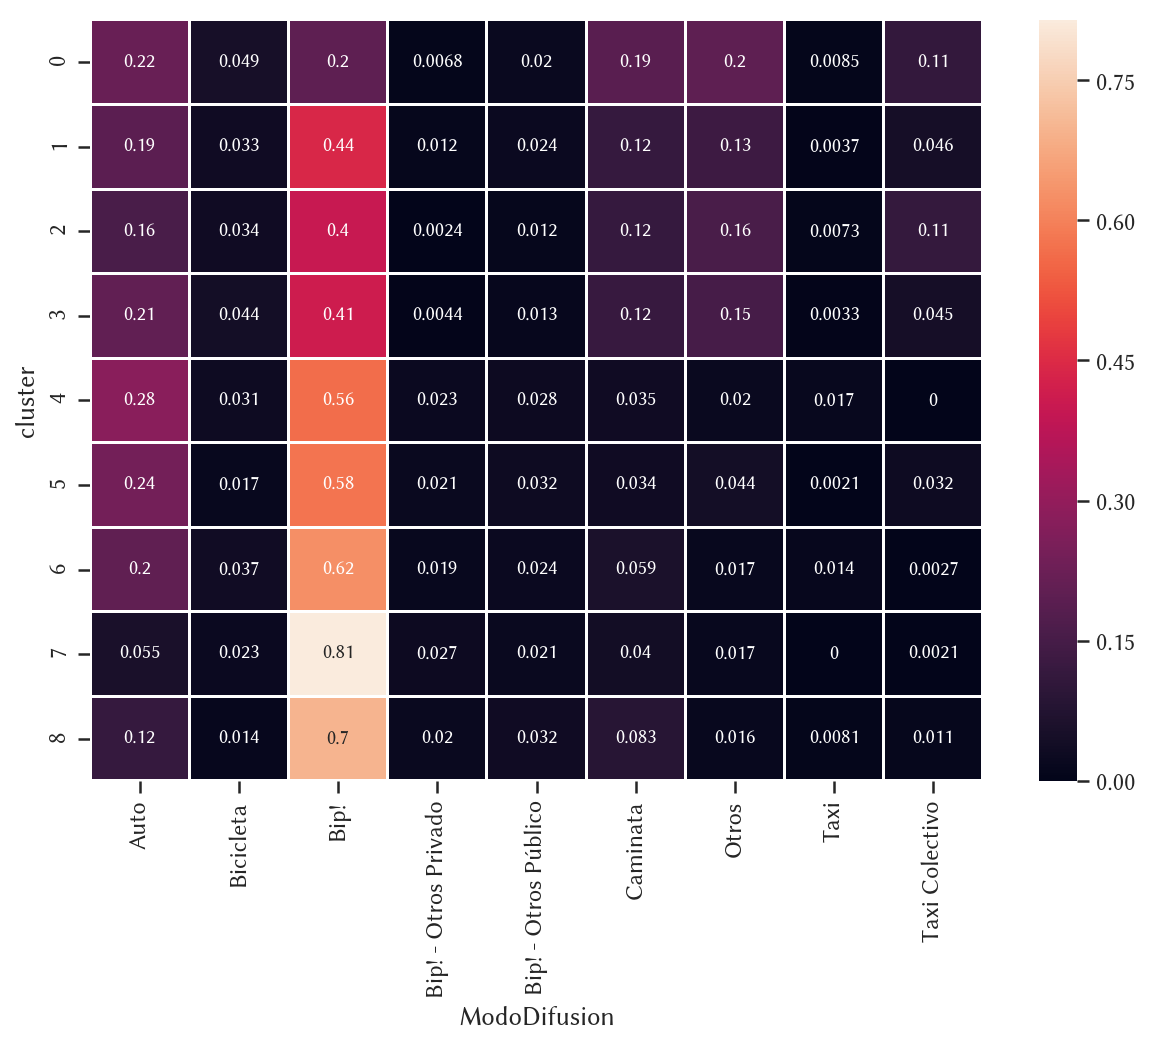

In [49]:
plt.figure(figsize=(10, 7))
sns.heatmap(mot_table, annot=True, linewidth=1)

Una manera de facilitar nuestro análisis es ordenar la tabla de acuerdo a la similitud de uso de modos de transporte y de distribuciones por cluster. Esto lo podemos hacer con el método `sns.clustermap` (y aprovechemos de usar una escala más fácil de ver):

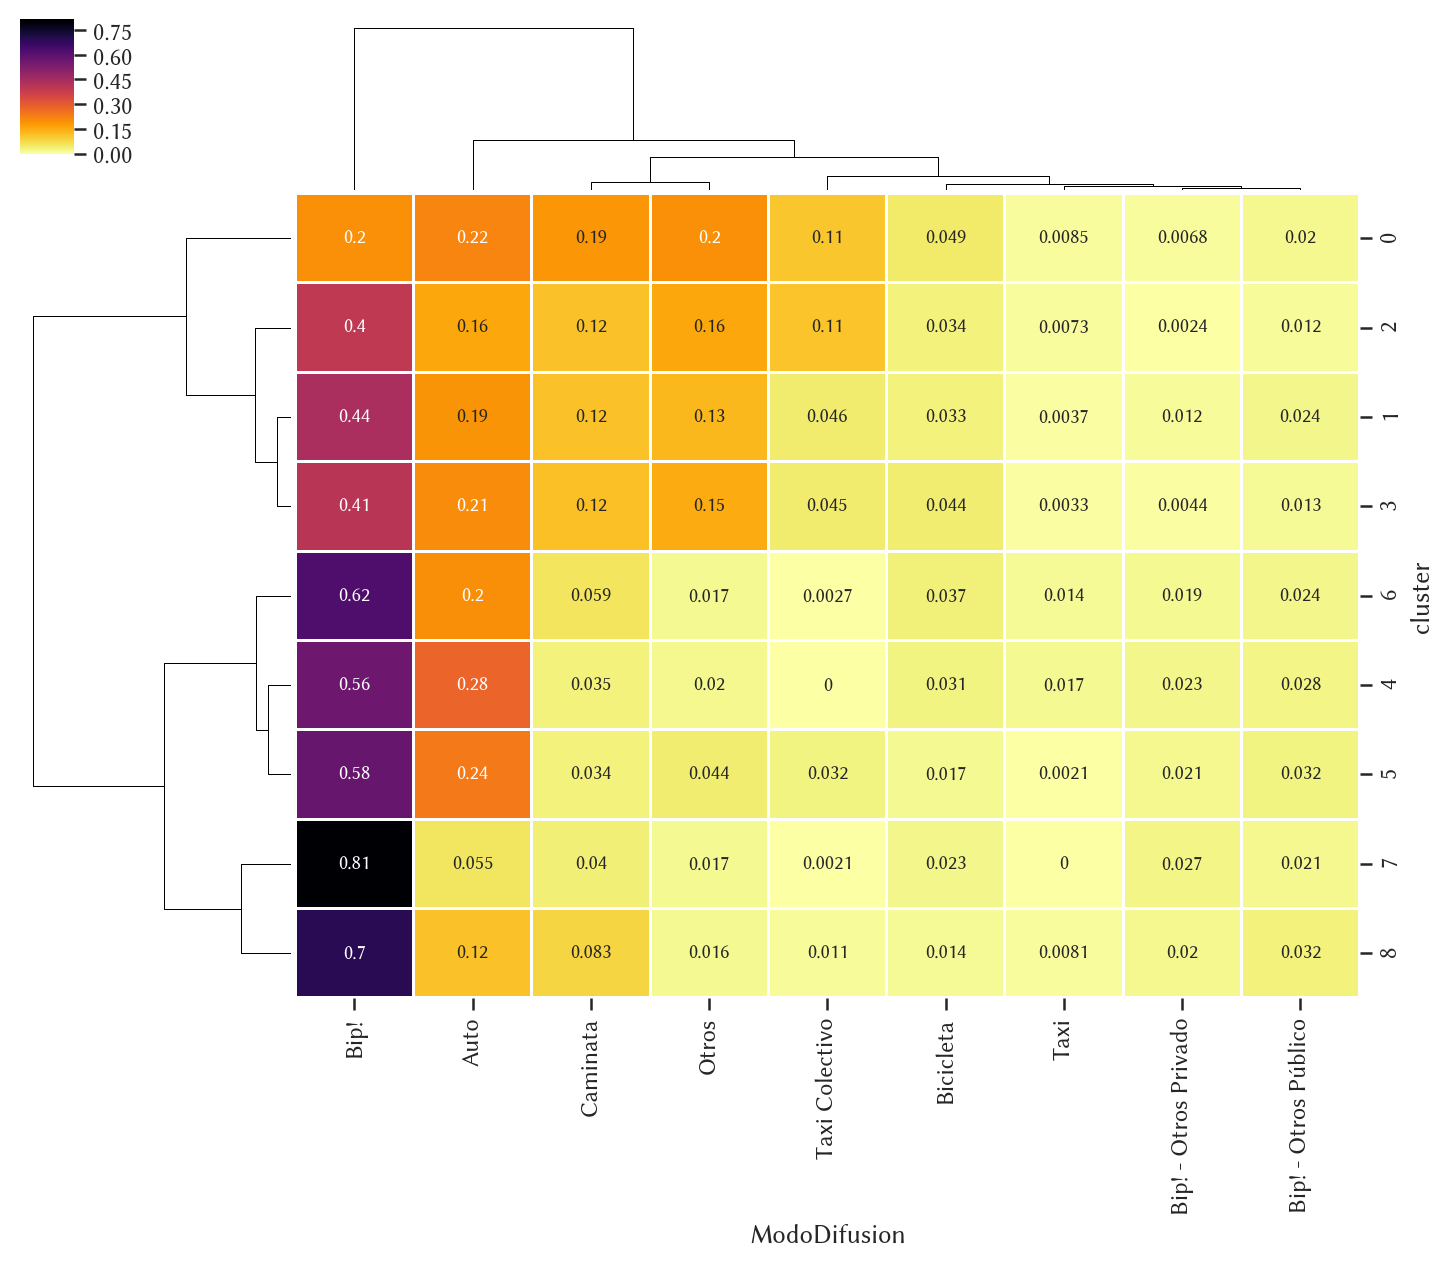

In [52]:
sns.clustermap(mot_table, annot=True, linewidth=1, figsize=(12, 9), cmap='inferno_r', method='ward')

Otra pregunta que podría ser interesante es: ¿cuál es el ingreso de las personas que trabajan / estudian en esos lugares? Analicemos la variable `IngresoHogar`:

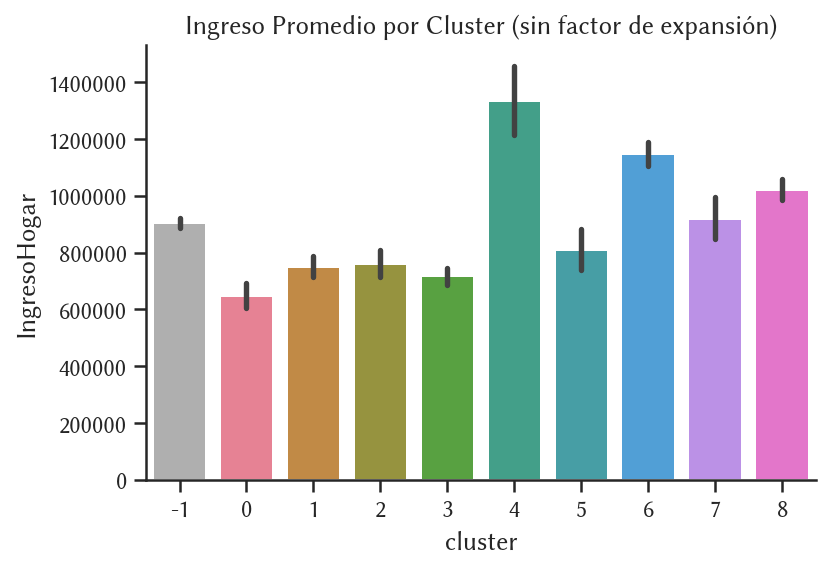

In [53]:
sns.barplot(x='cluster', y='IngresoHogar', data=analysis_trips, palette=palette)
sns.despine()
plt.title('Ingreso Promedio por Cluster (sin factor de expansión)');

Recordemos que el cluster 4 es el de Vitacura/Las Condes, el cluster 6 es el eje Providencia, y el cluster 8 es el centro histórico. ¿Les parece coherente?

### ¿Qué más hacer?

Aquí las posibilidades son vastas. Por ejemplo, se pueden hacer preguntas que caractericen a los clusters, como las dos que hemos hecho. 

Otra opción es tratar de buscar maneras de evaluar los resultados. Por ejemplo, comparando los clusters obtenidos con el uso de suelo del Servicio de Impuestos Internos, o los planes reguladores de cada comuna. ¿Coinciden los bordes obtenidos con los definidos por las autoridades?¿O el uso de la ciudad se desmarca de los bordes impuestos administrativamente?

Una tercera opción podría ser visualizar dónde vive la gente que trabaja en cada cluster:

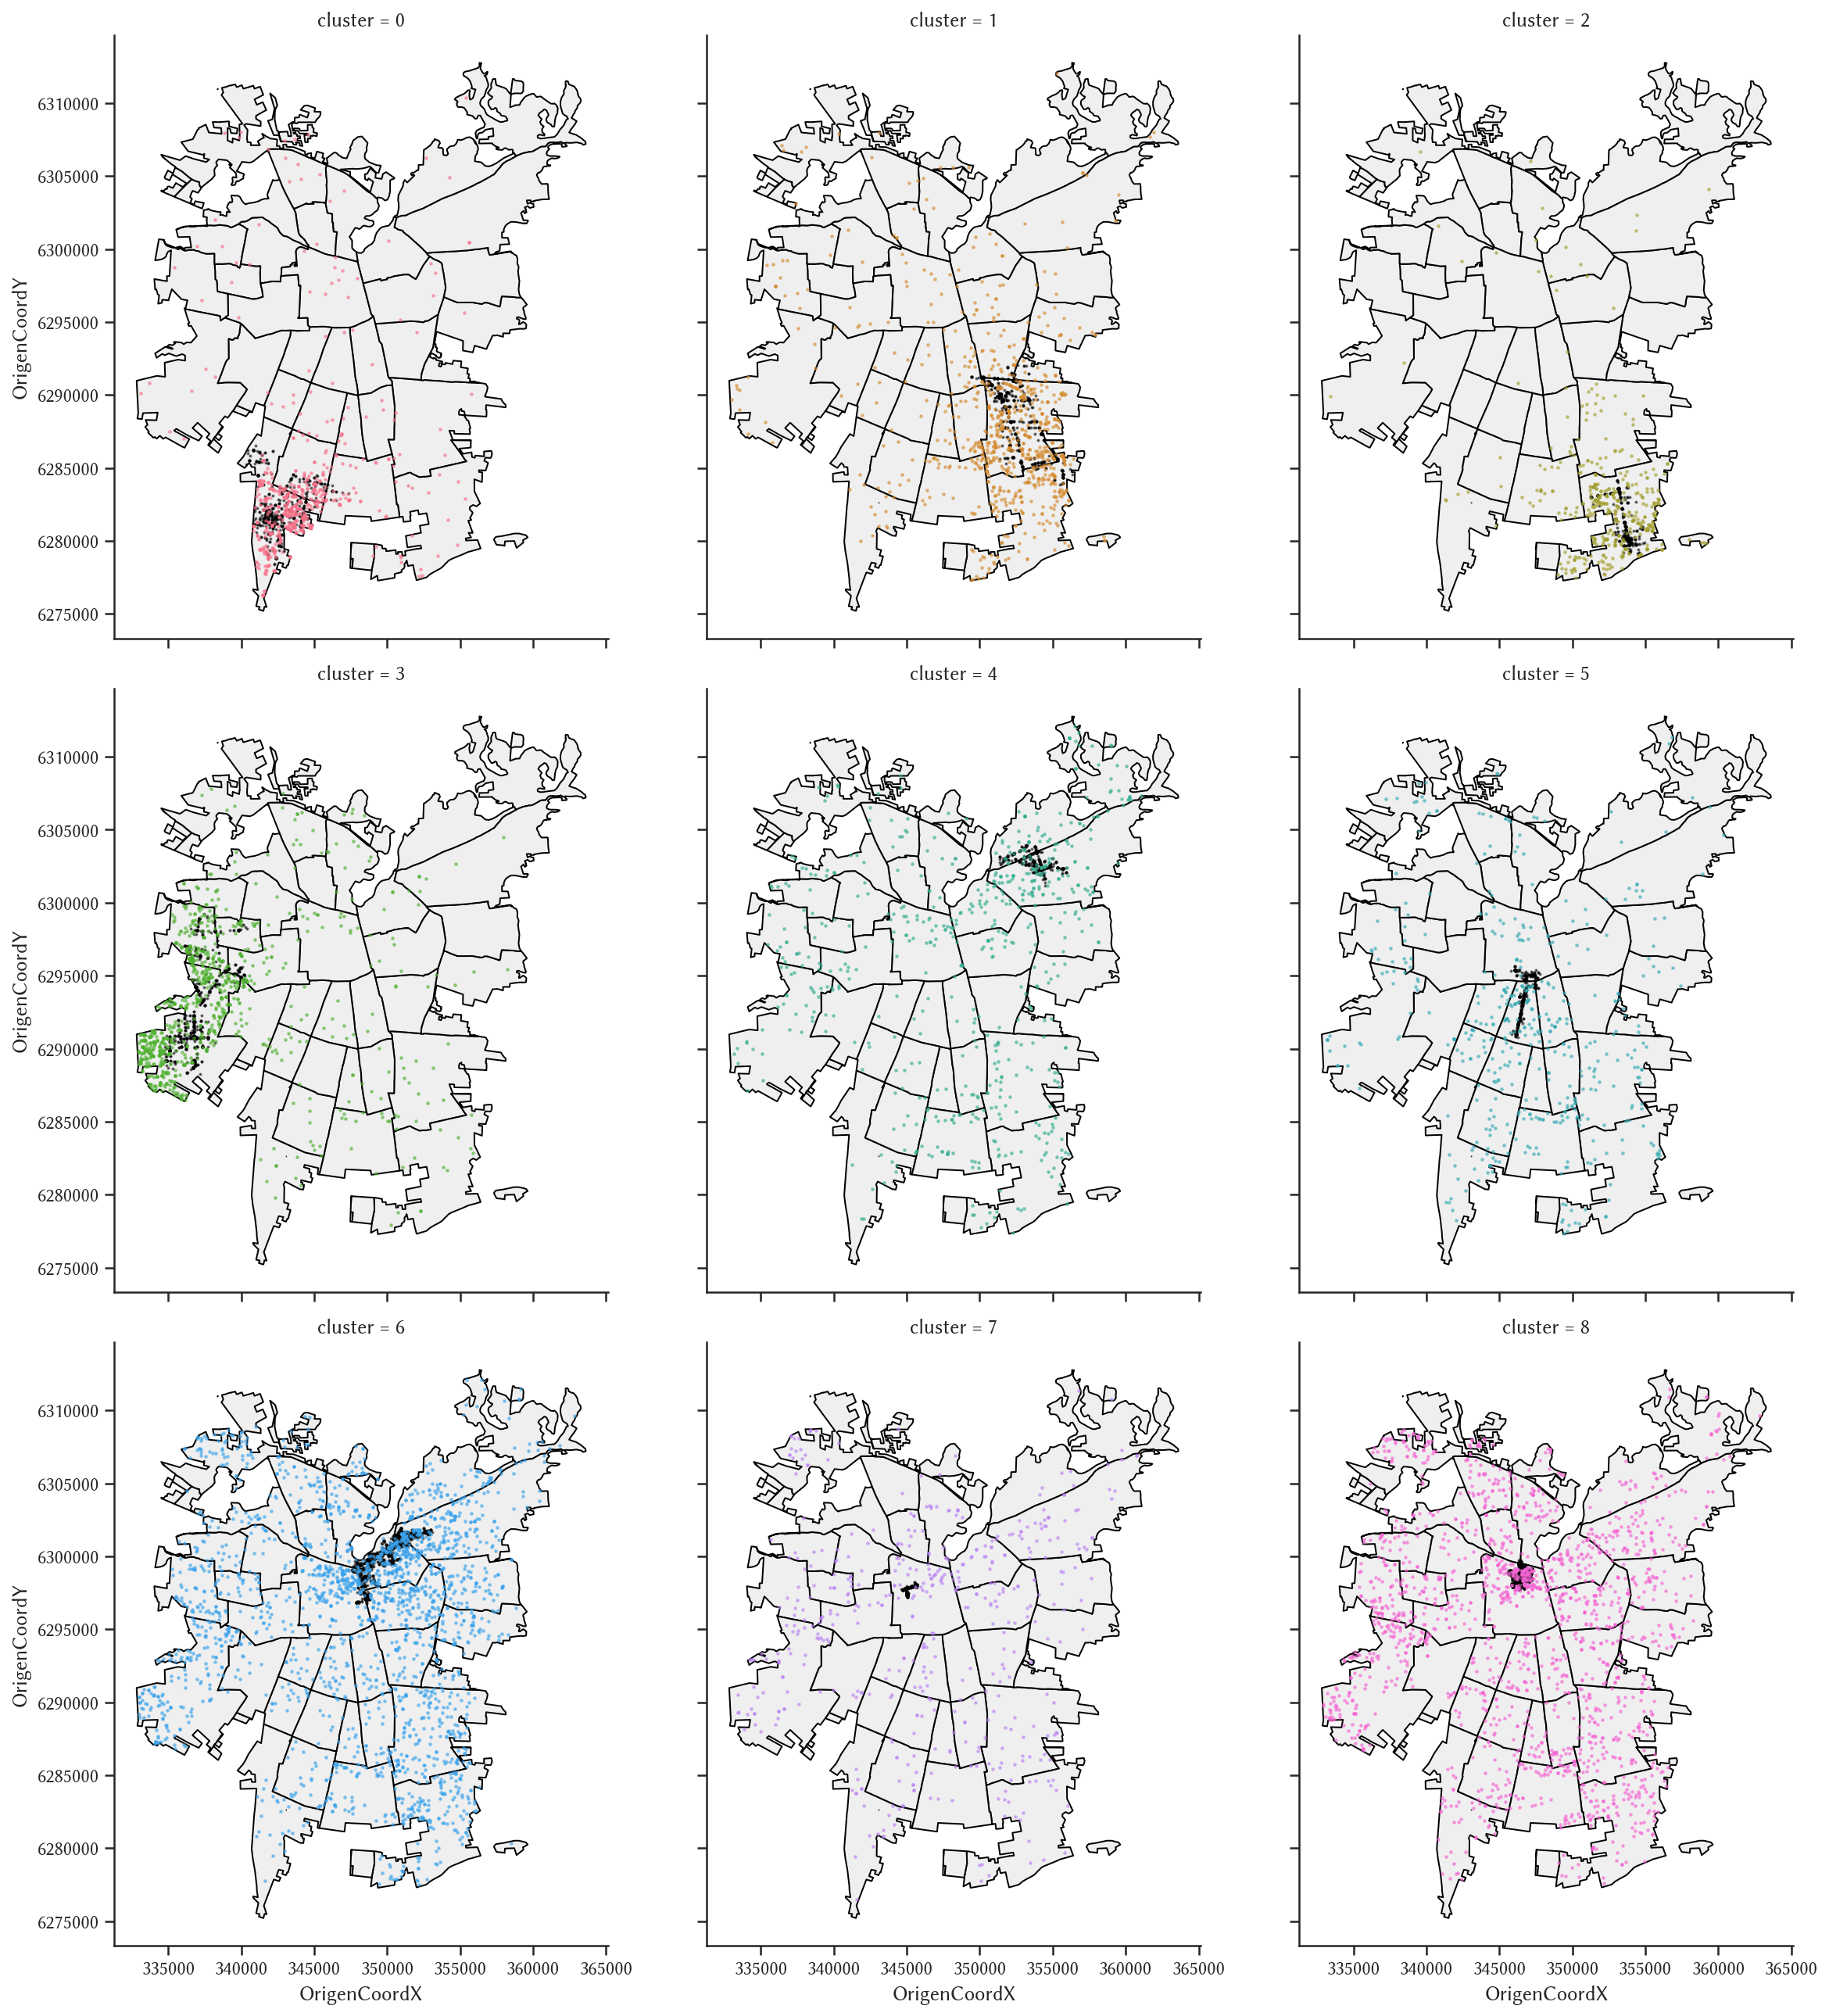

In [54]:
def plot_municipalities(**kwargs):
    ax = plt.gca()
    stgo_urban_municipalities.plot(ax=ax, facecolor='#efefef', edgecolor='black')

g = sns.FacetGrid(data=analysis_trips[analysis_trips.cluster >= 0], 
                  col='cluster', hue='cluster', palette=palette, aspect=1, height=6, col_wrap=3)
g.map(plot_municipalities)
g.map(plt.scatter, 'DestinoCoordX', 'DestinoCoordY', alpha=0.5, color='black', s=1)
g.map(plt.scatter, 'OrigenCoordX', 'OrigenCoordY', alpha=0.5, s=2)

## Esto continúa, pero depende de ustedes ;)

Como ven, es un algoritmo fácil de usar, y que, al mismo tiempo, tiene parámetros _algo_ intuitivos. 

Sin embargo, al igual que en todo otro modelo, ajustar los hiperparámetros requiere un trabajo constance y consciente. 

Y por supuesto también tiene limitaciones. Los datos que hemos utilizado son bidimensionales en lo que respecta al clustering. ¿Cómo podemos incorporar más variables?¿Qué pasa con las funciones de distancia cuando hay más dimensiones involucradas?¿Qué pasa cuando las dimensiones no tienen la misma semántica? Por ejemplo, uno pudiese querer clusterizar considerando también el ingreso de las personas. 

En conjunto con las preguntas exploratorias propuestas, entender las limitaciones y ventajas de un modelo son claves a la hora de decidir con qué quedarse. 
